# DSCI-6007 - TEAM - 01

# ->TITLE - GOOGLE STOCK PREDICTION

#### Required imports

In [1]:
pip install keras tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import s3fs
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

2024-04-23 15:34:26.717016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:34:27.908206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Read the file from the S3 bucket

In [3]:
s3 = s3fs.S3FileSystem()

# Specify the path to the CSV file in the S3 bucket
s3_path = 's3://dsci-6007-datafile/GOOGL.csv'

# Read the CSV file using pandas
dataset = pd.read_csv(s3.open(s3_path, 'rb'))

In [4]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [5]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [6]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [7]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
dataset.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4431 non-null   datetime64[ns]
 1   Open       4431 non-null   float64       
 2   High       4431 non-null   float64       
 3   Low        4431 non-null   float64       
 4   Close      4431 non-null   float64       
 5   Adj Close  4431 non-null   float64       
 6   Volume     4431 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 242.4 KB


In [10]:
# Extract the month from the 'Date' column
dataset['Month'] = dataset['Date'].dt.month

In [11]:
# Extract year from the 'Date' column
dataset['Year'] = dataset['Date'].dt.year

In [12]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,8,2004
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,8,2004
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,8,2004
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,8,2004
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,8,2004


#### Calculate the yearly growth based on the Close price

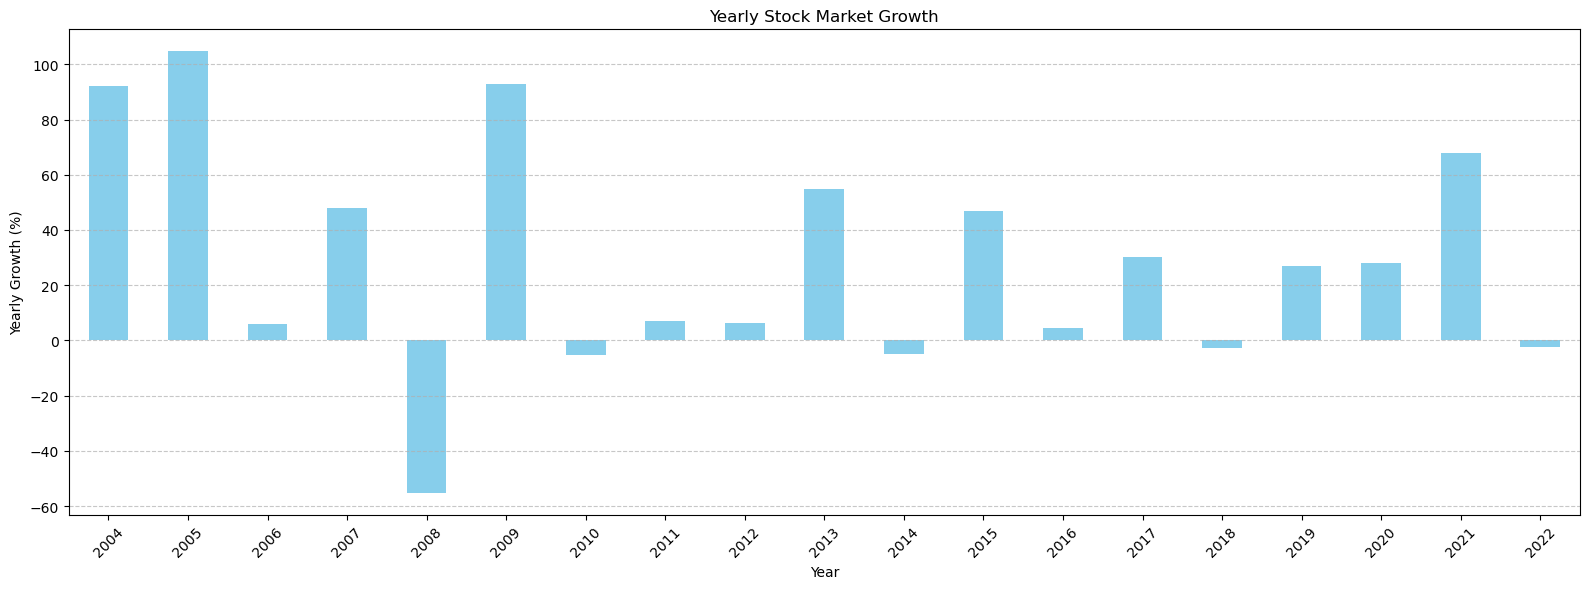

In [13]:
yearly_growth = dataset.groupby('Year').apply(lambda x: (x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0] * 100)

# Plot the yearly stock market growth
plt.figure(figsize=(16, 6))
yearly_growth.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Yearly Growth (%)')
plt.title('Yearly Stock Market Growth')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Calculate the monthly growth based on the Close price

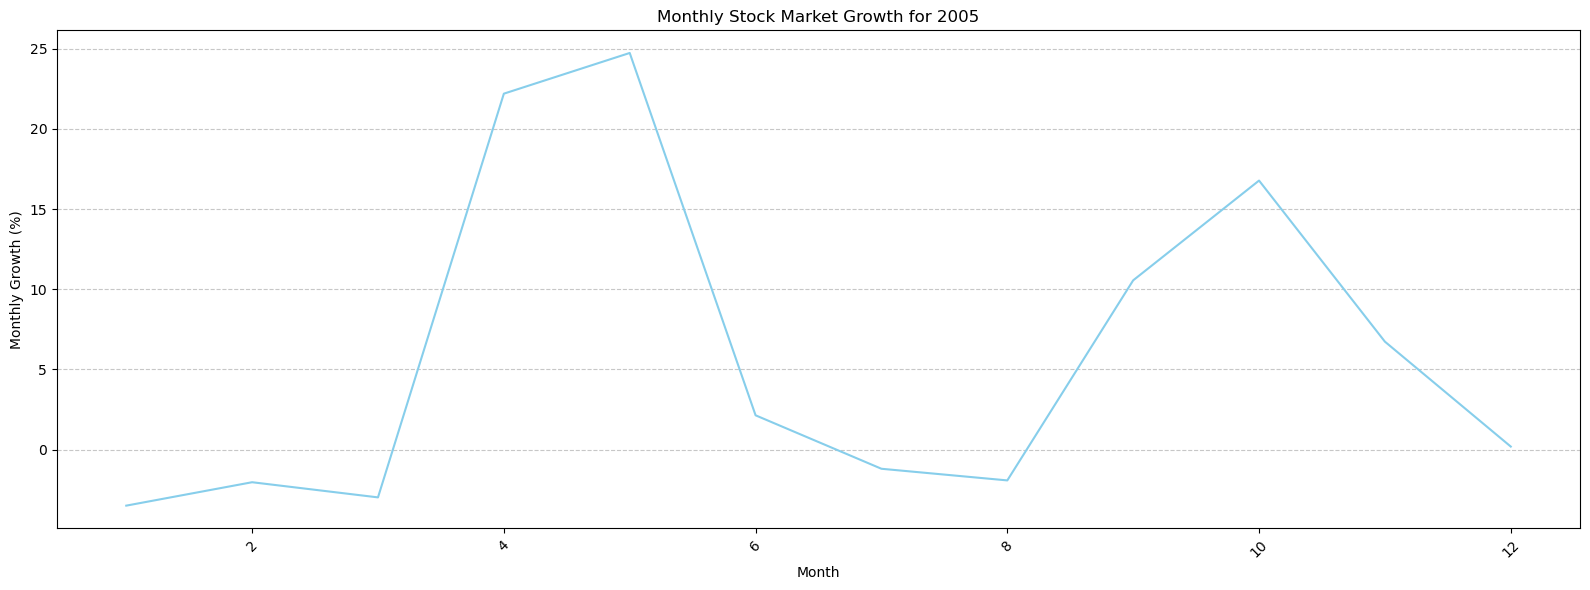

In [14]:
# Specifing the year which we want to look into
specified_year = 2005

# Filter the dataset for the specified year
dataset_year = dataset[dataset['Year'] == specified_year]

# Calculate the monthly growth based on the Close price for the specified year
monthly_growth_year = dataset_year.groupby('Month').apply(lambda x: (x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0] * 100)

# Plot the monthly stock market growth for the specified year
plt.figure(figsize=(16, 6))
monthly_growth_year.plot(kind='line', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Monthly Growth (%)')
plt.title('Monthly Stock Market Growth for {}'.format(specified_year))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
# Convert 'Close' column to numeric data type
dataset['Close'] = pd.to_numeric(dataset['Close'], errors='coerce')

<Axes: >

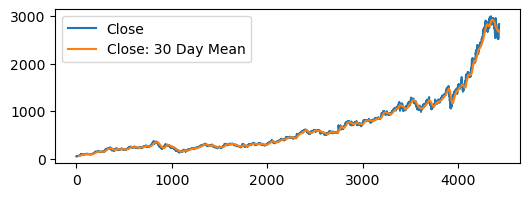

In [16]:
dataset['Close: 30 Day Mean'] = dataset['Close'].rolling(window=30).mean()
dataset[['Close','Close: 30 Day Mean']].plot(figsize=(6,2))

In [17]:
training_set=dataset['Open']
training_set=pd.DataFrame(training_set)

In [18]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [19]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
regressor = Sequential()

In [21]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

2024-04-23 15:34:30.765775: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [22]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 7.1967e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 7.4045e-05
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - loss: 7.0965e-05
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 5.7829e-05
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 4.3396e-05
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 4.6148e-05
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 5.8627e-05
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 3.7098e-05
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 3.6066e-05
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 3.7024e-05
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 3.4147e-05
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 3.1475e-05
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 3.1711e-05
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 2.8720e-05


In [23]:
dataset_test = pd.read_csv(s3.open(s3_path, 'rb'))

In [24]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [25]:
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [26]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [27]:
dataset_test["Volume"] = dataset_test["Volume"].replace(',', '').astype(float)

In [28]:
test_set=dataset_test['Open']
test_set=pd.DataFrame(test_set)

In [29]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4431 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


In [30]:
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 4450):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


In [31]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4390 entries, 0 to 4389
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4390 non-null   float32
dtypes: float32(1)
memory usage: 17.3 KB


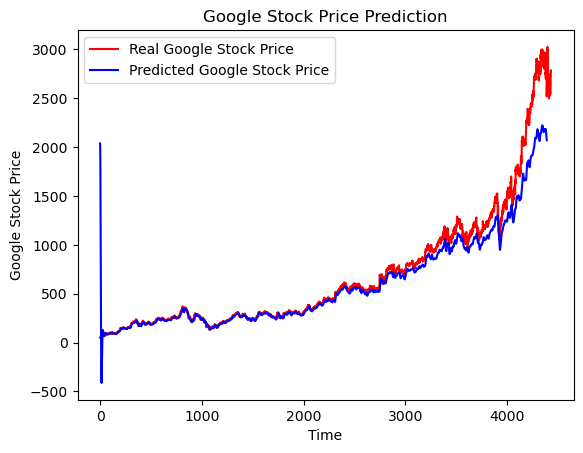

In [32]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

plt.show()